In [8]:
import torch
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

In [9]:
# use cuda if it is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# shape of the output image
imshape = (128, 128)

def image_loader(image_name):
    # scale imported image
    # transform it into a torch tensor
    loader = transforms.Compose([transforms.Resize(imshape),  transforms.ToTensor()])

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)   # add an additional dimension for fake batch (here 1)
    return image.to(device, torch.float) # move the image tensor to the correct device

In [10]:
image_path = "../data/"
content_image_name = "content.jpeg"
style_image_name = "style.jpeg"

content_image = image_loader(image_path + content_image_name)
style_image = image_loader(image_path + style_image_name)

Content image shape : 128 x 128
Style image shape : 128 x 128


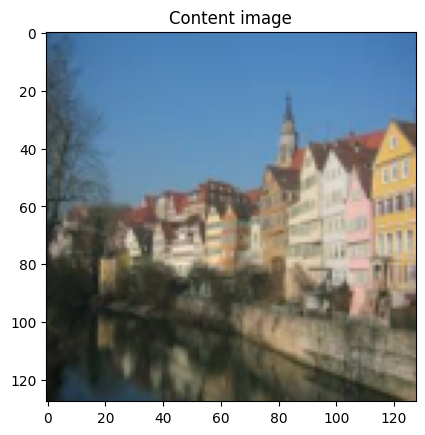

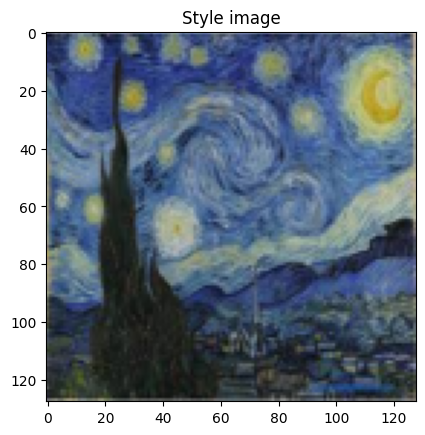

In [11]:
def image_display(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = tensor.cpu().clone()        # clone the tensor
    image = unloader(image.squeeze(0))  # remove the fake batch dimension
    plt.show()
    plt.imshow(image)
    if title is not None:
        plt.title(title)

content_height, content_width = content_image.shape[2], content_image.shape[3]
style_height, style_width = style_image.shape[2], style_image.shape[3]

print(f"Content image shape : {content_height} x {content_width}")
print(f"Style image shape : {style_height} x {style_width}")

image_display(content_image, "Content image")
image_display(style_image, "Style image")